In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx


import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import KBinsDiscretizer
import plotly.express as px

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from matplotlib.colors import ListedColormap
import folium
from folium.plugins import MarkerCluster,HeatMap,HeatMapWithTime
import branca.colormap as colormap
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import geopandas as gpd
from shapely.geometry import Point

# GNN Model

In [2]:
json_file_path = "../GNN/nodes_and_links_countries.json"

with open(json_file_path, 'r') as j:
     jdict = json.loads(j.read())
     
path = "../GNN/countries of the world.csv"
df_gdp = pd.read_csv(path,decimal=',')

In [3]:
df_gdp['Country'] = df_gdp['Country'].map(lambda x: str(x)[:-1])

correspondence = {
   'Micronesia, Fed. St.':'Federated States of Micronesia',
   'Antigua & Barbuda':'Antigua and Barbuda',
   'Bahamas, The':'Bahamas',
   'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
   'Trinidad & Tobago':'Trinidad and Tobago',
   'Central African Rep.': 'Central African Republic',
   'Congo, Dem. Rep.':'Democratic Republic of the Congo',
   'Congo, Repub. of the':'Republic of the Congo',
   "Cote d'Ivoire": "Côte d'Ivoire",
   'Gambia, The': 'The Gambia',
   'Sao Tome & Principe':'São Tomé and Príncipe',
   'Bosnia & Herzegovina': 'Bosnia and Herzegovina',
   'Macedonia':'North Macedonia',
   'China': "People's Republic of China",
   'Korea, North':'North Korea',
   'Korea, South':'South Korea',
   'Burma':'Myanmar'
    }

df_gdp = df_gdp.replace({"Country": correspondence})

countries_df = df_gdp['Country'].values
countries_nodes = ([node['name'] for node in jdict['nodes']])

mismatch = [i for i in countries_nodes if i not in countries_df]
nodes = set(countries_nodes)-set(mismatch)
nodes_df = [i for i in nodes]

df = df_gdp[df_gdp['Country'].isin(nodes_df)]

df.drop(['Region'], axis=1, inplace=True)

c:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
df_filtered = df.copy()
df_filtered['Infant mortality (per 1000 births)'] = df['Infant mortality (per 1000 births)'].apply(np.log10)
df_filtered['GDP ($ per capita)'] = df['GDP ($ per capita)'].apply(np.log10)
df_filtered['Phones (per 1000)'] = df['Phones (per 1000)'].apply(np.log10)
df_filtered['Pop. Density (per sq. mi.)'] = df['Pop. Density (per sq. mi.)'].apply(np.log10)
df_filtered['Other (%)'] = df['Other (%)'].apply(np.sqrt)
df_filtered['Literacy (%)'] = df['Literacy (%)'].apply(np.sqrt)

In [5]:
df_test = df_filtered.copy()

class_values = sorted(df_test["Country"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}

df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])

df_test=df_test.dropna()

df_test['GDP'] =df_test['GDP ($ per capita)']

df_test.drop(['GDP ($ per capita)'], axis=1, inplace=True)

In [6]:
existing_countries = df_test.Country.to_list()

edges = []
for n in jdict['links']:
    if (n['source'] in existing_countries) and (n['target'] in existing_countries):
        edges.append((n['source'], n['target']))
        
df_edges= pd.DataFrame.from_records(edges, columns =['source', 'target'])

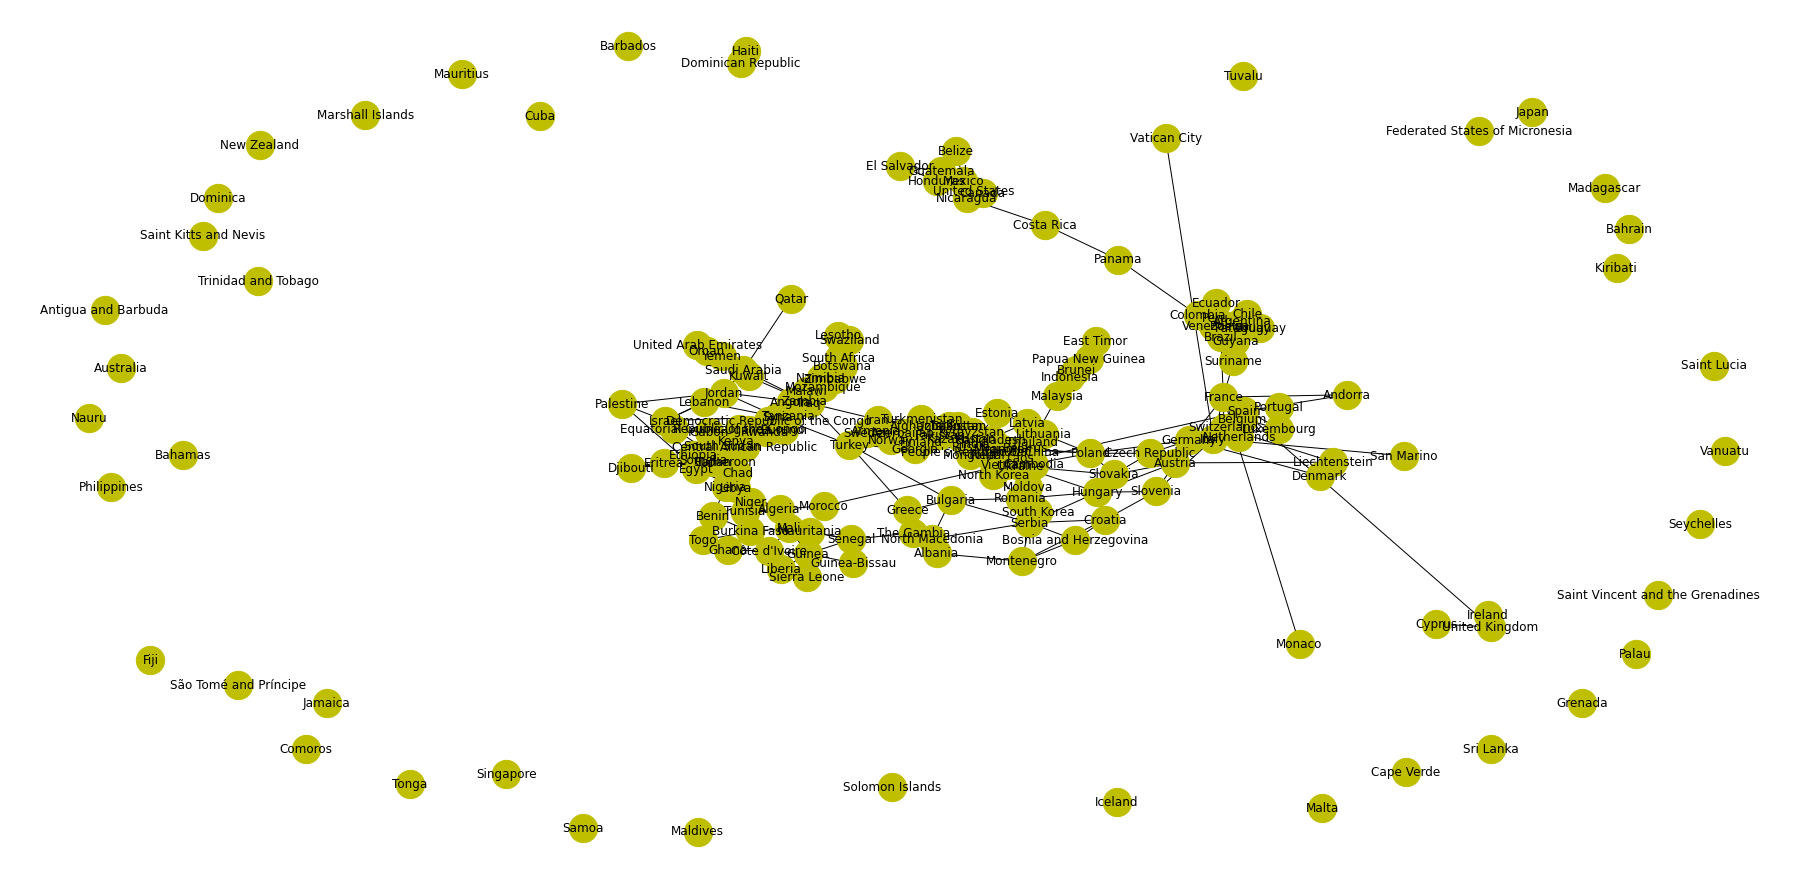

In [7]:
G = nx.Graph()
G.add_nodes_from([node['name'] for node in jdict['nodes']])
G.add_weighted_edges_from([(edge['source'], edge['target'], edge['border'])
                  for edge in jdict['links']])

pos = nx.spring_layout(G, k=.6)
plt.figure(figsize=(25,12))
nx.draw(G, 
        pos=pos,
        node_size=800, 
        with_labels=True, 
        node_color='y')
plt.show()

In [8]:
class_values = sorted(df_test["Country"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}

df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])

df_edges["source"] = df_edges["source"].apply(lambda name: class_idx[name])
df_edges["target"] = df_edges["target"].apply(lambda name: class_idx[name])

In [9]:
feature_names = set(df_test.columns) - {"Country", "GDP", 'Country ID'}
num_features = len(feature_names)
num_classes = num_features

In [10]:
train_data, test_data = [], []

for _, group_data in df_test.groupby("GDP"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.7
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

y_train = train_data["GDP"]
y_test = test_data["GDP"]

In [11]:
DROPOUT_RATE  =0.2

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

def run_experiment(model, x_train, y_train):
    model.compile(
        optimizer=keras.optimizers.Adam(1e-1),
        loss='mse',
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="loss", patience=50, restore_best_weights=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=5000,
        batch_size=2048,
        validation_split=0.2,
        callbacks=[early_stopping],

    )

    return history

class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=DROPOUT_RATE,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        messages = self.ffn_prepare(node_repesentations)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        num_nodes = node_repesentations.shape[0]
        aggregated_message = tf.math.unsorted_segment_mean(
            neighbour_messages, node_indices, num_segments=num_nodes
        )
        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        node_embeddings = self.update_fn(h)
        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        node_repesentations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        return self.update(node_repesentations, aggregated_messages)

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=DROPOUT_RATE,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x1 + x
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x2 + x
        x = self.postprocess(x)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)

In [12]:
edges = df_edges[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    df_test.sort_values("Country")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

graph_info = (node_features, edges, edge_weights)

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=[32, 32],
    dropout_rate=DROPOUT_RATE,
    name="gnn_model",
)

In [13]:
gnn_model([1,10])

<tf.Tensor: shape=(2, 17), dtype=float32, numpy=
array([[-2.6181660e+04, -5.7248688e+04,  2.3274898e+05, -3.8127766e+05,
         3.9626836e+04,  8.9750906e+04,  1.1421875e+01, -1.2257489e+05,
         5.2835211e+04,  2.8257260e+04,  9.2291289e+04, -2.4643617e+05,
         4.8324562e+04, -1.8565947e+05,  1.3257078e+05, -1.3848166e+05,
        -1.2857835e+05],
       [-5.1360410e+03, -1.1049139e+04,  4.5204387e+04, -7.3962750e+04,
         7.7708774e+03,  1.7306229e+04,  1.0962891e+02, -2.3675988e+04,
         1.0322898e+04,  5.5160850e+03,  1.7901148e+04, -4.7800281e+04,
         9.3699531e+03, -3.6056598e+04,  2.5843295e+04, -2.6827076e+04,
        -2.4986541e+04]], dtype=float32)>

In [14]:
x_train = train_data['Country ID'].to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/5000
1/1 [==============================] - 4s 4s/step - loss: 13.6943 - val_loss: 10.1026
Epoch 2/5000
1/1 [==============================] - 0s 31ms/step - loss: 5.2548 - val_loss: 34.7804
Epoch 3/5000
1/1 [==============================] - 0s 26ms/step - loss: 13.8388 - val_loss: 45.1824
Epoch 4/5000
1/1 [==============================] - 0s 32ms/step - loss: 3.3881 - val_loss: 14.6538
Epoch 5/5000
1/1 [==============================] - 0s 25ms/step - loss: 3.8127 - val_loss: 6.1064
Epoch 6/5000
1/1 [==============================] - 0s 32ms/step - loss: 3.1380 - val_loss: 4.5525
Epoch 7/5000
1/1 [==============================] - 0s 32ms/step - loss: 2.4176 - val_loss: 4.7995
Epoch 8/5000
1/1 [==============================] - 0s 30ms/step - loss: 2.4864 - val_loss: 8.8220
Epoch 9/5000
1/1 [==============================] - 0s 30ms/step - loss: 1.4533 - val_loss: 15.2171
Epoch 10/5000
1/1 [==============================] - 0s 31ms/step - loss: 1.3643 - val_loss: 18.7638
Epo

In [15]:
x_test = test_data['Country ID'].to_numpy()

mse_train = gnn_model.evaluate(x=x_train, y=y_train, verbose=0)
mse_test = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)

print(np.sqrt(mse_train), np.sqrt(mse_test))

0.2084867846088039 0.20328123246587962


In [16]:
test_data.head()

,Country,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,Country ID,GDP
135,Mexico,107449525,1972550,1.736397,0.47,-4.87,1.320354,9.602083,2.259116,12.99,1.31,9.257429,1.5,20.69,4.74,0.038,0.259,0.702,93,3.954243
27,Brazil,188078227,8511965,1.344392,0.09,-0.03,1.471438,9.295160,2.352761,6.96,0.90,9.599479,2.0,16.56,6.17,0.084,0.400,0.516,20,3.880814
61,El Salvador,6822378,21040,2.510947,1.46,-3.74,1.399674,8.955445,2.153510,31.85,12.07,7.488658,2.0,26.61,5.78,0.099,0.302,0.599,44,3.681241
11,Australia,20264082,7686850,0.414973,0.34,3.98,0.671173,10.000000,2.752433,6.55,0.04,9.664885,1.0,12.14,7.51,0.038,0.262,0.700,6,4.462398
89,Haiti,8308504,27750,2.476252,6.38,-3.40,1.865992,7.273239,1.227887,28.30,11.61,7.751774,2.0,36.44,12.17,0.280,0.200,0.520,63,3.204120


In [17]:
predictions = pd.DataFrame(list(zip(x_test, gnn_model(x_test).numpy()[:,0], y_test))).rename(columns = {0 : "Country ID", 1: "GDP Prediction", 2: "Real GDP"})

gnn_predictions_test = predictions.merge(test_data[["Country", "Country ID"]], on = "Country ID", how = "left")

gnn_predictions_test

,Country ID,GDP Prediction,Real GDP,Country
0,93,3.794391,3.954243,Mexico
1,20,3.902547,3.880814,Brazil
2,44,3.596663,3.681241,El Salvador
3,6,4.198555,4.462398,Australia
4,63,3.191106,3.204120,Haiti
5,16,3.159768,3.041393,Benin
6,28,3.100585,3.041393,Central African Republic
7,30,3.973341,3.995635,Chile
8,153,4.147885,4.442480,United Kingdom
9,35,4.132317,4.195900,Czech Republic


In [18]:
predictions = pd.DataFrame(list(zip(x_train, gnn_model(x_train).numpy()[:,0], y_train))).rename(columns = {0 : "Country ID", 1: "GDP Prediction", 2: "Real GDP"})

gnn_predictions_train = predictions.merge(train_data[["Country", "Country ID"]], on = "Country ID", how = "left")

gnn_predictions_train

,Country ID,GDP Prediction,Real GDP,Country
0,5,3.633405,3.544068,Armenia
1,86,3.171738,2.778151,Malawi
2,94,3.457328,3.255273,Mongolia
3,142,3.743785,3.869232,Thailand
4,139,3.499474,3.518514,Syria
...,...,...,...,...
108,141,3.264996,3.000000,Tajikistan
109,137,4.176119,4.428135,Sweden
110,82,3.295777,3.477121,Lesotho
111,57,4.123546,4.301030,Greece


In [19]:
gnn_predictions = gnn_predictions_train.append(gnn_predictions_test)

gnn_predictions

,Country ID,GDP Prediction,Real GDP,Country
0,5,3.633405,3.544068,Armenia
1,86,3.171738,2.778151,Malawi
2,94,3.457328,3.255273,Mongolia
3,142,3.743785,3.869232,Thailand
4,139,3.499474,3.518514,Syria
...,...,...,...,...
45,33,4.015396,3.959041,Costa Rica
46,45,3.244790,3.431364,Equatorial Guinea
47,29,3.085136,3.079181,Chad
48,119,3.131600,3.113943,Rwanda


# RNN

In [20]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

RANDOM_SEED = 42
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [21]:
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)


In [22]:
df_latlong = pd.read_csv('../RNN/countries.csv')
df_latlong.drop(['Importance', 'Altitude'], axis=1, inplace=True)

df_gdp = pd.read_csv('../RNN/gdp_per_capita.csv')
df_gdp.drop(['Unnamed: 65', 'Code'], axis=1, inplace=True)

countries_df_latlong = df_latlong['Country'].values
countries_df_gdp = df_gdp['Country Name'].values

mismatch = [i for i in countries_df_latlong if i not in countries_df_gdp]

nodes = set(countries_df_latlong)-set(mismatch)
nodes_df = [i for i in nodes]

df = df_latlong[df_latlong['Country'].isin(nodes_df)]

df = pd.merge(df_latlong,df_gdp,how='inner',left_on=['Country'],right_on=['Country Name'])

df.drop(['Country Name'], axis=1, inplace=True)

df = df.rename({'Latitude': 'Lat', 'Longitude': 'Lon'}, axis=1)

GDP_years = list(set(df.columns) - {'Country', 'Lat', 'Lon'})

for column in GDP_years:
    df[column] = np.log10(df[column])

df = df.melt(id_vars=['Country', 'Lat', 'Lon'], 
        var_name="Year", 
        value_name="GDP")

data = df.copy()

In [23]:
lista_unica = unique(df['Country'].tolist())       

dataset = []
for pais in lista_unica:
   data_pais = df[df["Country"] == pais]
   latitude_pais = data_pais.Lat
   latitude_pais = latitude_pais.tolist()
   latitude_pais = latitude_pais[0]
   longitude_pais = data_pais.Lon
   longitude_pais = longitude_pais.tolist()
   longitude_pais = longitude_pais[0]
   linha = 0
   gdp =  data_pais.GDP
   gdp = gdp.tolist()
 
   while linha<len(gdp)-3: 
    #  dataset_array = []
    
     gdp_1 = gdp[linha]
     gdp_2 = gdp[linha+1]
     gdp_3 = gdp[linha+2]
     gdp_4 = gdp[linha+3]
     gdp_5 = gdp[linha+4]

    #  print("gdp_1 {0}".format(gdp_1))
    #  print("gdp_2 {0}".format(gdp_2))
    #  print("gdp_3 {0}".format(gdp_3))
    #  print("gdp_4 {0}".format(gdp_4))
    #  print("gdp_5 {0}".format(gdp_5))
     if math.isnan(gdp_1) or math.isnan(gdp_2) or math.isnan(gdp_3) or math.isnan(gdp_4) or math.isnan(gdp_5):
       nan = 0
      #  print(gdp_1[0])
      #  print("nan")
     else:
       dataset.append([latitude_pais, longitude_pais, gdp_1, gdp_2, gdp_3, gdp_4, gdp_5])

      
      # dataset.append(dataset_array)
     linha +=4

my_array = np.array(dataset)
dataset = my_array.astype('float32')
# Normalizando os Valores
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

n_steps = 6 #CADA LISTA DENTRO DA LISTA VAI TER 7 DADOS

setenta_porc= int((70*len(dataset))/100)
vint_poc = int((20*len(dataset))/100)
nov_porc=setenta_porc+vint_poc

X_train, y_train = dataset[:setenta_porc, :n_steps], dataset[:setenta_porc, -1]
X_valid, y_valid = dataset[setenta_porc:nov_porc, :n_steps], dataset[setenta_porc:nov_porc, -1]
X_test, y_test = dataset[nov_porc:, :n_steps], dataset[nov_porc:, -1]

y_pred = X_valid[:, -1]

model = keras.models.Sequential([
    # keras.layers.Flatten(input_shape=[6, 1]),
    keras.layers.Dense(1,input_shape=[6]),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=80, #20
    batch_size=128, #128
    validation_data=(X_valid, y_valid),
)

Epoch 1/80
11/11 [==============================] - 0s 11ms/step - loss: 0.4516 - val_loss: 0.2174
Epoch 2/80
11/11 [==============================] - 0s 3ms/step - loss: 0.1056 - val_loss: 0.0447
Epoch 3/80
11/11 [==============================] - 0s 3ms/step - loss: 0.0422 - val_loss: 0.0409
Epoch 4/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0457 - val_loss: 0.0356
Epoch 5/80
11/11 [==============================] - 0s 3ms/step - loss: 0.0360 - val_loss: 0.0297
Epoch 6/80
11/11 [==============================] - 0s 3ms/step - loss: 0.0307 - val_loss: 0.0284
Epoch 7/80
11/11 [==============================] - 0s 3ms/step - loss: 0.0276 - val_loss: 0.0245
Epoch 8/80
11/11 [==============================] - 0s 3ms/step - loss: 0.0243 - val_loss: 0.0211
Epoch 9/80
11/11 [==============================] - 0s 3ms/step - loss: 0.0216 - val_loss: 0.0184
Epoch 10/80
11/11 [==============================] - 0s 3ms/step - loss: 0.0190 - val_loss: 0.0162
Epoch 11/80
11/11 

In [24]:
X_train.shape, y_train.shape

((1332, 6), (1332,))

In [25]:
y_pred = X_valid[:, -1]

model = keras.models.Sequential([
    # keras.layers.Flatten(input_shape=[6, 1]),
    keras.layers.Dense(1,input_shape=[6]),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=80, #20
    batch_size=128, #128
    validation_data=(X_valid, y_valid),
)

Epoch 1/80
11/11 [==============================] - 0s 13ms/step - loss: 0.0881 - val_loss: 0.0057
Epoch 2/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0189
Epoch 3/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0043
Epoch 4/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 5/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 6/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 8/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 9/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 11/80
11/11 

In [26]:
model.evaluate(X_valid, y_valid)

12/12 [==============================] - 0s 997us/step - loss: 4.0559e-04


0.00040559095214121044

In [27]:
model.layers[0].get_weights()

[array([[ 6.3847345e-03],
        [ 1.3593934e-04],
        [ 5.8541763e-01],
        [-5.9941012e-01],
        [ 3.1623906e-01],
        [ 7.2125089e-01]], dtype=float32),
 array([-0.02192402], dtype=float32)]

In [28]:
y_pred = model.predict(X_valid)

12/12 [==============================] - 0s 997us/step


In [29]:
X_train = X_train.reshape((1332,1,6))
X_valid = X_valid.reshape((380,1,6))

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None,6]),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=20, #20
    batch_size=180, #180
    validation_data=(X_valid, y_valid),
)

y_pred = model.predict(X_valid)

X_valid = X_valid.reshape((380, 6))

Epoch 1/20
8/8 [==============================] - 1s 23ms/step - loss: 0.6188 - val_loss: 0.4265
Epoch 2/20
8/8 [==============================] - 0s 4ms/step - loss: 0.2809 - val_loss: 0.1643
Epoch 3/20
8/8 [==============================] - 0s 4ms/step - loss: 0.1114 - val_loss: 0.0760
Epoch 4/20
8/8 [==============================] - 0s 5ms/step - loss: 0.0661 - val_loss: 0.0620
Epoch 5/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0617 - val_loss: 0.0619
Epoch 6/20
8/8 [==============================] - 0s 5ms/step - loss: 0.0622 - val_loss: 0.0609
Epoch 7/20
8/8 [==============================] - 0s 5ms/step - loss: 0.0606 - val_loss: 0.0583
Epoch 8/20
8/8 [==============================] - 0s 4ms/step - loss: 0.0576 - val_loss: 0.0550
Epoch 9/20
8/8 [==============================] - 0s 4ms/step - loss: 0.0542 - val_loss: 0.0523
Epoch 10/20
8/8 [==============================] - 0s 4ms/step - loss: 0.0515 - val_loss: 0.0500
Epoch 11/20
8/8 [====================

In [30]:
X_train = X_train.reshape((1332,1,6))
X_valid = X_valid.reshape((380,1,6))

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None,6]),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=80, #20
    batch_size=180, #180
    validation_data=(X_valid, y_valid),
)

Epoch 1/80
8/8 [==============================] - 1s 29ms/step - loss: 0.0271 - val_loss: 0.0167
Epoch 2/80
8/8 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.0148
Epoch 3/80
8/8 [==============================] - 0s 5ms/step - loss: 0.0154 - val_loss: 0.0119
Epoch 4/80
8/8 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0098
Epoch 5/80
8/8 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.0068
Epoch 6/80
8/8 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0054
Epoch 7/80
8/8 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 8/80
8/8 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 9/80
8/8 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 10/80
8/8 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 11/80
8/8 [=====================

In [31]:
y_pred = model.predict(X_valid)

X_valid = X_valid.reshape((380, 6))

12/12 [==============================] - 0s 1ms/step


In [32]:
X_test = X_test.reshape((192,1,6))

y_pred = model.predict(X_test)

X_test = X_test.reshape((192, 6))


6/6 [==============================] - 0s 2ms/step


## RNN 2016

In [33]:
lista_unica = unique(df['Country'].tolist())

dataset_2016 = []
pais_lista=[]
maximo=0
for pais in lista_unica:
   data_pais = df[df["Country"] == pais]
   latitude_pais = data_pais.Lat
   latitude_pais = latitude_pais.tolist()
   latitude_pais = latitude_pais[0]
   longitude_pais = data_pais.Lon
   longitude_pais = longitude_pais.tolist()
   longitude_pais = longitude_pais[0]
   gdp =  data_pais.GDP
   gdp = gdp.tolist()
   gdp_1 = gdp[52]
   gdp_2 = gdp[53]
   gdp_3 = gdp[54]
   gdp_4 = gdp[55]
   gdp_5 = gdp[56]
   if math.isnan(gdp_1) or math.isnan(gdp_2) or math.isnan(gdp_3) or math.isnan(gdp_4) or math.isnan(gdp_5):
     nan = 0
      #  print(gdp_1[0])
      #  print("nan")
   else:
      if maximo < gdp_1 or maximo < gdp_2 or maximo < gdp_3 or maximo < gdp_4 or maximo < gdp_5:
        maximo = max(gdp_1,gdp_2,gdp_3,gdp_4,gdp_5)
      dataset_2016.append([latitude_pais, longitude_pais, gdp_1, gdp_2, gdp_3, gdp_4, gdp_5])
      pais_lista.append(pais)
      
      # dataset.append(dataset_array)

# print(dataset_2016)    


In [34]:
my_array = np.array(dataset_2016)
dataset_2016 = my_array.astype('float32')
# Normalizando os Valores
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_2016 = scaler.fit_transform(dataset_2016)

In [35]:
n_steps = 6
X_2016, y_2016 = dataset_2016[:, :n_steps], dataset_2016[:, -1]

In [36]:
y_2016.shape

(156,)

In [37]:
X_2016.shape

(156, 6)

In [38]:
X_2016 = X_2016.reshape((156,1,6))

In [39]:
print(model.evaluate(X_2016, y_2016))

5/5 [==============================] - 0s 1ms/step - loss: 0.0030
0.0030277108307927847


5/5 [==============================] - 0s 1ms/step


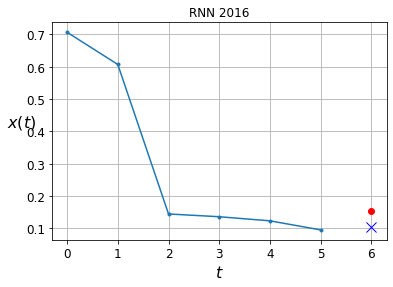

In [40]:
y_pred = model.predict(X_2016)

X_2016 = X_2016.reshape((156, 6))
plot_series(X_2016[0, :], y_2016[0], y_pred[0])
plt.title("RNN 2016")
plt.show()

In [41]:
print(y_2016)
y_2016_pred = y_pred.reshape(156)
# y_2016_pred=[]
# for y in y_pred

[0.10422927 0.42613715 0.41934484 0.7666554  0.40108806 0.6274026
 0.60078126 0.40481657 0.81077975 0.79583424 0.41675395 0.68867713
 0.25960892 0.64377457 0.4570753  0.7841839  0.45137733 0.2204315
 0.3734222  0.38092822 0.45570034 0.5073963  0.5414985  0.51984173
 0.14987189 0.         0.38362974 0.24434954 0.26089066 0.78539747
 0.06697798 0.1510331  0.6119862  0.5301866  0.4806283  0.5910849
 0.31550056 0.59758145 0.5295455  0.7017407  0.82490593 0.36650866
 0.529931   0.5138437  0.48552555 0.4137531  0.55078405 0.65591043
 0.39750212 0.1562131  0.47474843 0.790662   0.7648403  0.5074294
 0.4238041  0.7846368  0.31229275 0.652746   0.556963   0.4279688
 0.15944248 0.14374512 0.47905964 0.24685568 0.33779103 0.60456055
 0.84430665 0.29232174 0.40356523 0.4413256  0.8463617  0.76605564
 0.7370836  0.45095664 0.7743848  0.42804474 0.5227768  0.27265638
 0.41185898 0.7197556  0.61823505 0.52154976 0.16124886 0.42277616
 0.9959672  0.6253523  0.92828757 0.09296143 0.02965438 0.5599709
 

In [42]:
data = {'Pais': pais_lista ,
        '2016':[(item * maximo) for item in y_2016] ,
         '2016 predição':[(item * maximo) for item in y_2016_pred],
        }

df = pd.DataFrame(data)
df

,Pais,2016,2016 predição
0,Afghanistan,0.550065,0.804797
1,Albania,2.248919,2.603776
2,Algeria,2.213073,2.728586
3,Andorra,4.045989,3.948054
4,Angola,2.116724,2.652044
...,...,...,...
151,Uzbekistan,1.905398,2.147642
152,Vietnam,1.734320,1.896275
153,West Bank and Gaza,2.121711,2.359879
154,Zambia,1.296705,1.748963


In [43]:
gnn_predictions

,Country ID,GDP Prediction,Real GDP,Country
0,5,3.633405,3.544068,Armenia
1,86,3.171738,2.778151,Malawi
2,94,3.457328,3.255273,Mongolia
3,142,3.743785,3.869232,Thailand
4,139,3.499474,3.518514,Syria
...,...,...,...,...
45,33,4.015396,3.959041,Costa Rica
46,45,3.244790,3.431364,Equatorial Guinea
47,29,3.085136,3.079181,Chad
48,119,3.131600,3.113943,Rwanda


# MERGE MODELS

In [44]:
stacked_base = gnn_predictions[['Country','GDP Prediction','Real GDP']].merge(df[['Pais','2016 predição']], left_on='Country',right_on = "Pais", how='inner')

stacked_base

,Country,GDP Prediction,Real GDP,Pais,2016 predição
0,Armenia,3.633405,3.544068,Armenia,2.503450
1,Malawi,3.171738,2.778151,Malawi,0.119991
2,Mongolia,3.457328,3.255273,Mongolia,2.605391
3,Thailand,3.743785,3.869232,Thailand,2.826694
4,Ireland,4.227263,4.471292,Ireland,4.078301
...,...,...,...,...,...
121,Costa Rica,4.015396,3.959041,Costa Rica,3.160744
122,Equatorial Guinea,3.244790,3.431364,Equatorial Guinea,3.543912
123,Chad,3.085136,3.079181,Chad,1.220366
124,Rwanda,3.131600,3.113943,Rwanda,0.884859


In [45]:
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor

In [46]:

x_train, x_test, y_train, y_test = train_test_split(
    stacked_base.drop(['Country','Pais','Real GDP'], axis=1),
    stacked_base['Real GDP'],
    test_size = 0.2,
    random_state=RANDOM_SEED,
)

In [47]:
rfc_clf = RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=150)
rfc_clf.fit(x_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=42)

In [48]:
tr = cross_val_score(rfc_clf, x_train, y_train, cv=3, scoring='neg_mean_squared_error')
tst = cross_val_score(rfc_clf, x_test, y_test, cv=3, scoring='neg_mean_squared_error')

In [49]:
print(f"Model mse on train: {-1*tr.mean()}\nModel mse on test: {-1*tst.mean()}")

Model mse on train: 0.029424444571510666
Model mse on test: 0.02086690736534365


In [50]:
from sklearn.metrics import mean_squared_error

rfc_clf.fit(x_train, y_train)

y_pred = rfc_clf.predict(x_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

Regressão random forest: RMSE = 0.12
